# Style Transfer 

CNN based algorith for transfering artistic style from one image to the other

Prisma fueled art is a hit

https://github.com/jcjohnson/neural-style

![jcjohnson](resources/neural_art_jcjohnson.png)


http://genekogan.com/works/style-transfer/


[![genekogan](resources/style_transfer_genekogan.png)](http://genekogan.com/images/style-transfer/picasso-periods.mp4 "Genekogan")


## Recipy for neural art

1. Train your network on a classification problem
2. Choose high level neurons to capture base image content
3. Choose low/mid level neurons to capture stylistic information 
4. Change your image to maximize activations on those neurons
4. Repeat 3. till you are happy



#### Convolutional neural network architecture

[![cnn architecture](resources/cnn.png)](http://www.cognitivetoday.com/2016/10/deep-learning-neural-networks-simplified.html)

*http://www.cognitivetoday.com/2016/10/deep-learning-neural-networks-simplified.html*

When image goes in it activates certain neurons creating image signature
![gatys paper](resources/gatys.png)

*"Image Style Transfer Using Convolutional Neural Networks" L. A. Gatys 2016*

### Train your network on a classifcation problem

We use pretrained VGG16 network (top5 accuracy 90%)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from ipywidgets import interact

import sys,os,glob
import numpy as np
sys.path.append('/home/jakub.czakon/deep_learning_art_webinar')
import utils

Using TensorFlow backend.


## Lets make some art

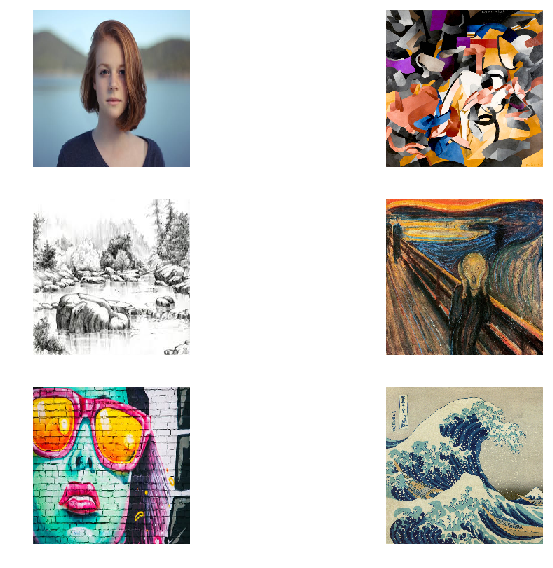

In [2]:
import keras.preprocessing.image as img_utils
from matplotlib import pyplot as plt

img_nrows,img_ncols = 224,224
img_size = (img_nrows, img_ncols, 3)

img_filename_list = sorted(utils.get_images_from_directory(dir_path='data',
                                                    extensions = ['jpg','jpeg']))

img_list = [img_utils.load_img(f,target_size= img_size[:2]) 
            for f in img_filename_list]
img_tensors_list = [utils.img2vggtensor(im) for im in img_list]

utils.plot_list(img_list)

In [3]:
base_image,base_image_tensor = img_list[0], img_tensors_list[0]
style_image,style_image_tensor = img_list[2], img_tensors_list[2]
combined_image_dir = 'results'

In [4]:
import keras.backend as K

base = K.variable(base_image_tensor)
style = K.variable(style_image_tensor)
combination= K.placeholder((1,)+img_size)

input_tensor = K.concatenate([base,style,combination], axis=0)

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input,decode_predictions
from keras.preprocessing import image as img_utils
from keras.layers import Input


input_template = Input(batch_shape=(1,) + img_size)

img_recognition_network = VGG16(input_tensor=input_tensor, 
                                weights='imagenet', 
                                include_top=True)

#### Stylistic loss

In [7]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return 0.5*K.sum(K.square(combination - base))

def total_variation_loss(x):
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

*Original Gatys paper feature representations*

In [8]:
content_feature_names = 'block4_conv2'
style_feature_names = ['block1_conv1', 'block2_conv1','block3_conv1','block4_conv1',
                       'block5_conv1']

*Original Gatys paper 10e-3 style weight to content weight ratio*

In [9]:
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1.0

print content_weight/style_weight

0.025


In [11]:
layer_dict = utils.get_layer_dict_name(img_recognition_network)

content_features = layer_dict[content_feature_names].output

base_image_features = content_features[0, :, :, :]
combination_features = content_features[2, :, :, :]

loss = K.variable(0.)

# CONTENT LOSS
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

# STYLE LOSS
for layer_name in style_feature_names:
    layer_features = layer_dict[layer_name].output
    
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    style_loss_chunk = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_feature_names)) * style_loss_chunk

# VARIATIONAL LOSS    
loss += total_variation_weight * total_variation_loss(combination)
    
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination)

outputs = [loss] + grads

f_outputs = K.function([combination], outputs)

In [12]:
def eval_loss_and_grads(x):
    x = x.reshape((1,) + img_size)
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')

    return loss_value, grad_values

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

('Start of iteration', 0)
('Current loss value:', 2.9520548e+09)


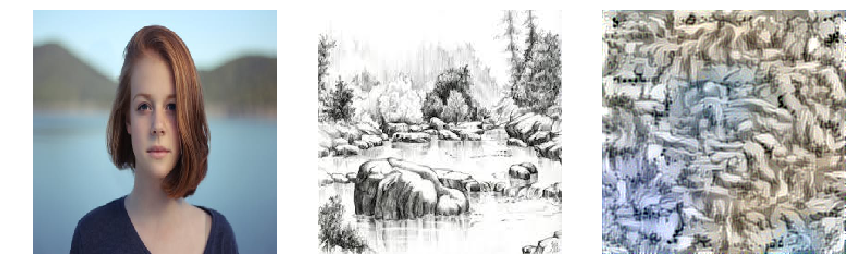

Iteration 0 completed in 8s
('Start of iteration', 1)
('Current loss value:', 1.646529e+09)


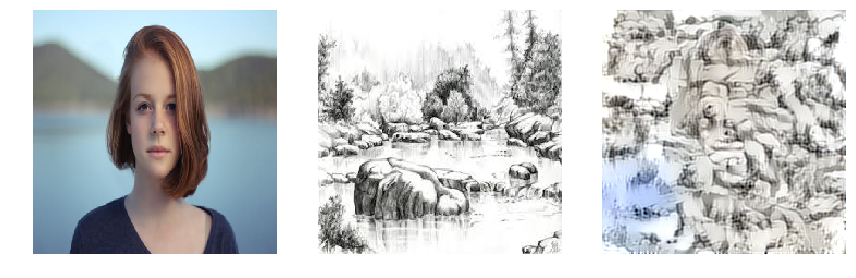

Iteration 1 completed in 4s
('Start of iteration', 2)
('Current loss value:', 1.432581e+09)


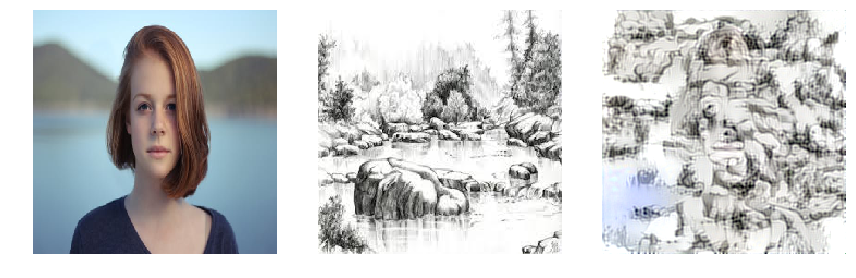

Iteration 2 completed in 4s
('Start of iteration', 3)
('Current loss value:', 1.3371479e+09)


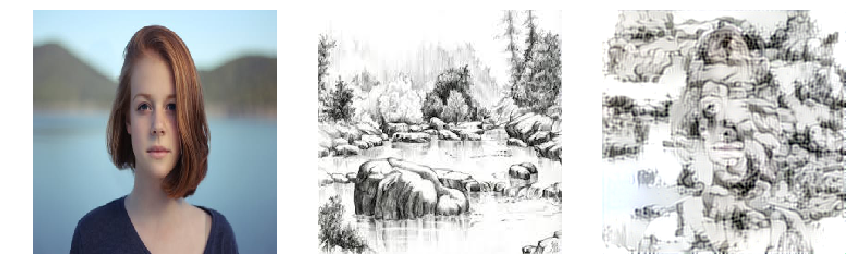

Iteration 3 completed in 4s
('Start of iteration', 4)
('Current loss value:', 1.284795e+09)


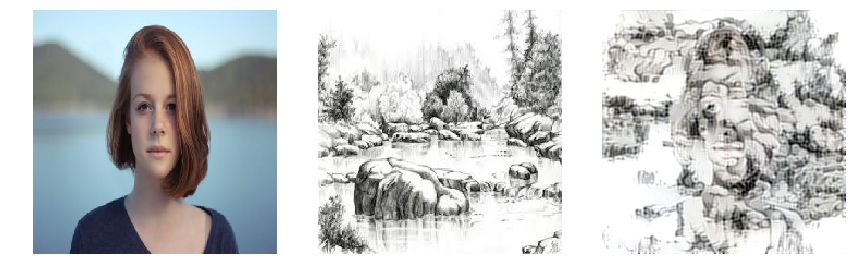

Iteration 4 completed in 4s
('Start of iteration', 5)
('Current loss value:', 1.2567927e+09)


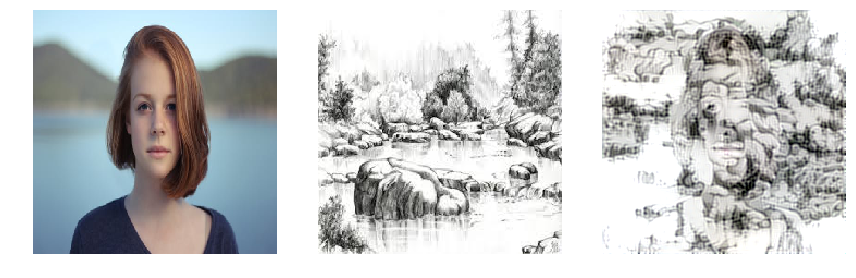

Iteration 5 completed in 4s
('Start of iteration', 6)


In [ ]:
import time

from scipy.optimize import fmin_l_bfgs_b
from matplotlib import pyplot as plt

evaluator = Evaluator()

x = np.random.uniform(0, 255, (1,)+img_size) - 128.

for i in range(100):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=40)
    print('Current loss value:', min_val)

    img = utils.deprocess_image(np.copy(x))
    plt.imsave(os.path.join(combined_image_dir,
                            "girl_{}_{}_{}.jpg".format(content_weight,
                                                          style_weight,
                                                          i)
                            ),img)
    utils.plot_list([base_image,style_image,img],cols_nr=3)

    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))